# Submarine Volcanism: Satellite Extraction

Description: This Jupyter Notebook extracts chlorophyll and sea surface temperature for the Axial Seamount off the US West Coast. This notebook is a modification of the Data_Access.ipynb from the OceanHackWeek Tutorials. 

By Kelly Luis on August 4, 2021

**Axial Seamount Location**:    
Latitude: 45.95°N    
Longitude: 130°W    
Source: [Smithsonian Institution National Museum of Natural History Global Volcanism Program](https://volcano.si.edu/volcano.cfm?vn=331021)

**Datasets Available**:
1) OOI: Regional Cabled Array: Axial Base Shallow Profiler Mooring: 200m Platform (PC03A): 2-Wavelength Fluorometer & Regional Cabled Array: Axial Base Shallow Profiler Mooring: Shallow Profiler (SF03A): 3-Wavelength Fluorometer

2) CoastWatch: 

In [1]:
%matplotlib inline
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import warnings

warnings.filterwarnings("ignore")

import pandas as pd

## Step 1: Visualize Axial Seamount 

In [2]:
from ipyleaflet import Map, FullScreenControl, Rectangle, Marker

# Function to Map Seamounts
def map_mount(mount_lat, mount_lon, deg=2):
    
    """
    Variable (data type): Description

    mount_lat (float): Latitude (decimal degrees) of Sea Mount
    mount_lon (float): Longitude (decimal degrees) of Sea Mount (only works for negative lon values)
    deg (float): Degrees off of mount coordinates to establish bounding box 
    """

    #TODO: Longitudes only work for negatives (need to add in an if statement)
    min_lon, max_lon = mount_lon+deg, mount_lon-deg
    min_lat, max_lat = mount_lat-deg, mount_lat+deg

    rectangle = Rectangle(
        bounds=((min_lat, min_lon), (max_lat, max_lon))
    )

    m = Map(
        center=((min_lat + max_lat) / 2, (min_lon + max_lon) / 2),
        zoom=6,
    )
    
    
    marker = Marker(location=(mount_lat, mount_lon), draggable=False)
    
    m.add_layer(rectangle)
    m.add_layer(marker)
    m.add_control(FullScreenControl())
    
    return m

In [3]:
ax_lat, ax_lon = 45.95, -130

map_mount(ax_lat,ax_lon)

Map(center=[45.95, -130.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

## Step 2: Find OOI Array Data Within Bounding Box

In [4]:
def ooi_search(mount_lat, mount_lon, start_date, end_date, dataset_name="mass_concentration_of_chlorophyll_a_in_sea_water", deg=2):

    """
    Variable (data type): Description
    
    mount_lat (float): Latitude (decimal degrees) of Sea Mount
    mount_lon (float): Longitude (decimal degrees) of Sea Mount (only works for negative lon values)
    deg (float): Degrees off of mount coordinates to establish bounding box. Default is 2 degrees 
    start_time (str): Start date
    end_time (str): End date
    dataset_name (str): ERDAPP dataset name
    deg (float): Degrees off of mount coordinates to establish bounding box
    """
    
    from erddapy import ERDDAP

    # OOI
    ooi_server = (
        "http://erddap.dataexplorer.oceanobservatories.org/erddap"
    )

    ooi_e = ERDDAP(
        server=ooi_server,
        protocol="tabledap"
    )


    # Establish Bounding Box
    min_lon, max_lon = mount_lon+deg, mount_lon-deg
    min_lat, max_lat = mount_lat-deg, mount_lat+deg
    
    # Make Dates in UTC: %Y-%m-%dT%H:%M:%S.%fZ

    start_time="%sT00:00:00Z" % (start_date)
    end_time="%sT00:00:00Z" % (end_date)    
    
    # Piece together kw
    kw = {
        "min_time": start_time,
        "max_time": end_time, 
        "min_lon": min_lon,
        "max_lon": max_lon,
        "min_lat": min_lat,
        "max_lat": max_lat,
        "standard_name": dataset_name,
    }
    
    search_url = ooi_e.get_search_url(response="csv", **kw)
    search = pd.read_csv(search_url)
    dataset_ids = search["Dataset ID"].values

    dataset_ids_list = "\n".join(dataset_ids)
    
    # Print Datasets Found
    print(f"Found {len(dataset_ids)} Datasets:\n{dataset_ids_list} \n")

    return dataset_ids


In [5]:
# Axial Seamount 2015 Eruption
erupt_start = "2015-04-01"
erupt_end = "2015-05-31"

datasetID_list = ooi_search(ax_lat, ax_lon, erupt_start, erupt_end)

Found 2 Datasets:
ooi-rs03axps-pc03a-4c-flordd303
ooi-rs03axps-sf03a-3a-flortd301 



In [6]:
# TODO: Make more adaptable to other cabledArray 

def extract_cabledArray(dataset_id, mount_lat, mount_lon, start_date, end_date, deg=2):

    """
    Variable (data type): Description
    

    """
    
    from erddapy import ERDDAP

    # OOI
    ooi_server = (
        "http://erddap.dataexplorer.oceanobservatories.org/erddap"
    )

    ooi_e = ERDDAP(
        server=ooi_server,
        protocol="tabledap"
    )

    # Pull Variables 
    sal = "sea_water_practical_salinity"
    temp = "sea_water_temperature"
    chl = "mass_concentration_of_chlorophyll_a_in_sea_water"
    cdom = "cdomflo"
    sct = "flubsct"

    ooi_e.dataset_id = dataset_id
    print(f"Reading Dataset: {ooi_e.dataset_id} \n")

    ooi_e.variables = [
        "z",
        "latitude",
        "longitude",
        sal,
        temp,
        chl,
        cdom,
        sct,
        "time",
    ]
    
    # Set Constraints: Bounding Box & Time
    min_lon, max_lon = mount_lon+deg, mount_lon-deg
    min_lat, max_lat = mount_lat-deg, mount_lat+deg
    
    # Dates in UTC: %Y-%m-%dT%H:%M:%S.%fZ
    start_time="%sT00:00:00Z" % (start_date)
    end_time="%sT00:00:00Z" % (end_date)   
    
    ooi_e.constraints = {
     "time>=": start_time,
     "time<=": end_time,
     "latitude>=": min_lat,
     "latitude<=": max_lat,
     "longitude>=": max_lon,
     "longitude<=": min_lon,
    }

    # Get URL
    url = ooi_e.get_download_url()
    print(f"ERDDAP URL: {url} \n")
    
    # Read to Pandas
    df = ooi_e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True
    ).dropna()
    
    return df

In [7]:
df = extract_cabledArray('ooi-rs03axps-pc03a-4c-flordd303',  ax_lat, ax_lon, erupt_start, erupt_end)

Reading Dataset: ooi-rs03axps-pc03a-4c-flordd303 

ERDDAP URL: http://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-rs03axps-pc03a-4c-flordd303.html?z,latitude,longitude,sea_water_practical_salinity,sea_water_temperature,mass_concentration_of_chlorophyll_a_in_sea_water,cdomflo,flubsct,time&time>=1427846400.0&time<=1433030400.0&latitude>=43.95&latitude<=47.95&longitude>=-132&longitude<=-128 



### Explore Regional Array Data

In [8]:
# Look at Head
df.head()

,z (m),latitude (degrees_north),longitude (degrees_east),sea_water_practical_salinity (1e-3),sea_water_temperature (degree_Celsius),mass_concentration_of_chlorophyll_a_in_sea_water (microg.L-1),cdomflo (1e-9),flubsct (m-1)
time (UTC),,,,,,,,
2015-04-01 00:00:00+00:00,0.0,45.83049,-129.75326,33.722550,8.830508,-0.040053,1.390279,0.000824
2015-04-01 00:01:00+00:00,0.0,45.83049,-129.75326,33.722574,8.829198,-0.036140,1.284645,0.000729
2015-04-01 00:02:00+00:00,0.0,45.83049,-129.75326,33.723437,8.827876,-0.038181,1.326072,0.000667
2015-04-01 00:03:00+00:00,0.0,45.83049,-129.75326,33.724471,8.826553,-0.037521,1.420947,0.000678
2015-04-01 00:04:00+00:00,0.0,45.83049,-129.75326,33.726148,8.825243,-0.036140,1.376649,0.000716


In [9]:
# Summary Statistics
df.describe()

,z (m),latitude (degrees_north),longitude (degrees_east),sea_water_practical_salinity (1e-3),sea_water_temperature (degree_Celsius),mass_concentration_of_chlorophyll_a_in_sea_water (microg.L-1),cdomflo (1e-9),flubsct (m-1)
count,44545.0,4.454500e+04,4.454500e+04,44545.000000,44545.000000,44545.000000,44545.000000,44545.000000
mean,0.0,4.583049e+01,-1.297533e+02,33.789868,8.247342,-0.035383,1.490770,0.000728
std,0.0,3.197478e-11,4.922695e-11,0.046233,1.380595,0.190078,0.143388,0.000604
min,0.0,4.583049e+01,-1.297533e+02,33.608161,7.201330,-0.049721,0.927627,0.000498
25%,0.0,4.583049e+01,-1.297533e+02,33.760890,7.482271,-0.041344,1.403909,0.000633
50%,0.0,4.583049e+01,-1.297533e+02,33.793995,7.580877,-0.038859,1.489098,0.000684
75%,0.0,4.583049e+01,-1.297533e+02,33.824102,8.038679,-0.036140,1.574287,0.000733
max,0.0,4.583049e+01,-1.297533e+02,33.892944,13.276948,30.133770,6.920728,0.043781


### Plot OOI Array Variables for 2015
Red vertical line when 2015 Axial Seamount Eruption

Text(0.5, 1.0, 'Optical Backscatter')

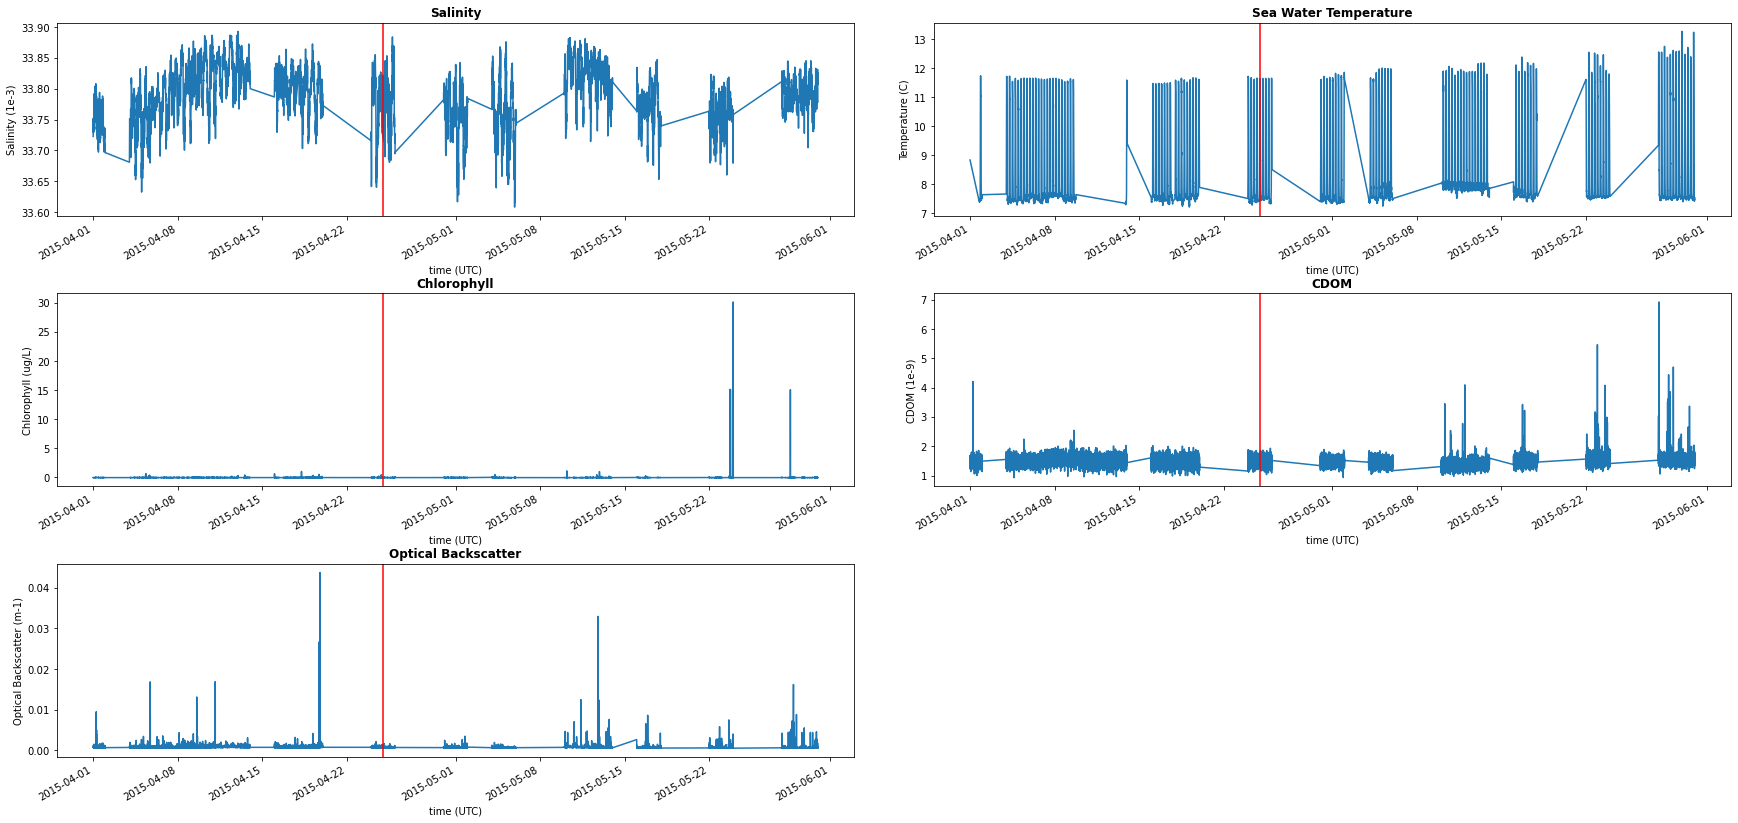

In [10]:
import matplotlib.pyplot as plt
import datetime as dt

# Variable Names:
sal = "sea_water_practical_salinity"
temp = "sea_water_temperature"
chl = "mass_concentration_of_chlorophyll_a_in_sea_water"
cdom = "cdomflo"
sct = "flubsct"

#TODO: Make a Prettier Plotting Function
eruption_yr=2015
eruption_month=4
eruption_date=25

fig = plt.figure(figsize=(30, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.1)
ax1 = fig.add_subplot(3, 2, 1)
df[f"{sal} (1e-3)"]["2015"].dropna().plot(ax=ax1);
ax1.axvline(dt.datetime(eruption_yr, eruption_month, eruption_date), color='r')
ax1.set_ylabel('Salinity (1e-3)')
ax1.set_title('Salinity', fontweight='bold')

ax2 = fig.add_subplot(3, 2, 2)
df[f"{temp} (degree_Celsius)"]["2015"].dropna().plot(ax=ax2)
ax2.axvline(dt.datetime(eruption_yr, eruption_month, eruption_date), color='r')
ax2.set_ylabel('Temperature (C)')
ax2.set_title('Sea Water Temperature', fontweight='bold')

ax3 = fig.add_subplot(3, 2, 3)
df[f"{chl} (microg.L-1)"]["2015"].dropna().plot(ax=ax3)
ax3.axvline(dt.datetime(eruption_yr, eruption_month, eruption_date), color='r')
ax3.set_ylabel('Chlorophyll (ug/L)')
ax3.set_title('Chlorophyll', fontweight='bold')

ax4 = fig.add_subplot(3, 2, 4)
df[f"{cdom} (1e-9)"]["2015"].dropna().plot(ax=ax4)
ax4.axvline(dt.datetime(eruption_yr, eruption_month, eruption_date), color='r')
ax4.set_ylabel('CDOM (1e-9)')
ax4.set_title('CDOM', fontweight='bold')

ax5 = fig.add_subplot(3, 2, 5)
df[f"{sct} (m-1)"]["2015"].dropna().plot(ax=ax5)
ax5.axvline(dt.datetime(eruption_yr, eruption_month, eruption_date), color='r')
ax5.set_ylabel('Optical Backscatter (m-1)')
ax5.set_title('Optical Backscatter', fontweight='bold')


### Additional Analyses of Interest:
1) Time Series Work: Weekly, Monthly, or Seasonal Averaging/ Smoothing


## Step 3: Extract Satellite Data for 2015

We're going to extract daily sea surface temperature and 14-day chlorophyll data from NOAA's WestCoast Node. You can find more dataset IDS [here](https://coastwatch.pfeg.noaa.gov/erddap/search/index.html?page=1&itemsPerPage=1000&searchFor=chlorophyll).

Dataset Ids:
1) Chlorophyll-a, Aqua MODIS, NPP, 0.0125°, West US, EXPERIMENTAL, 2002-present (14 Day Composite), Lon+/-180, Lon0360: erdMWchla14day_LonPM180
**Pay attention to the bounding box size with respect to the spatial resolution of the satellite product** 

2) Sea Surface Temperature, GHRSST Global 1-km Sea Surface Temperature (G1SST), Global, 0.01 Degree, 2010-2017, Daily): jplG1SST

In [11]:
def extract_coastWatch(dataset_id, mount_lat, mount_lon, start_date, end_date, deg=2, node="CSWC"):
    
    from erddapy import ERDDAP
    import json

    coastWatch_e = ERDDAP(
        server=node,  
        protocol="griddap",
    )

    coastWatch_e.dataset_id = (
        dataset_id
    )

    coastWatch_e.griddap_initialize()
    
    print(f"variables in this dataset:\n\n{coastWatch_e.variables}")
    print(
    f"\nconstraints of this dataset:\n\n{json.dumps(coastWatch_e.constraints, indent=1)}"
    )

    print(f"Reading Dataset: {coastWatch_e.dataset_id} \n")

    # Set Constraints: Bounding Box & Time
    min_lon, max_lon = mount_lon+deg, mount_lon-deg
    min_lat, max_lat = mount_lat-deg, mount_lat+deg
    
    # Dates in UTC: %Y-%m-%dT%H:%M:%S.%fZ
    start_time="%sT00:00:00Z" % (start_date)
    end_time="%sT00:00:00Z" % (end_date)    

    coastWatch_e.constraints["time>="] = start_date
    coastWatch_e.constraints["time<="] = end_date 
    coastWatch_e.constraints["latitude>="] = min_lat
    coastWatch_e.constraints["latitude<="] = max_lat
    coastWatch_e.constraints["longitude>="] = max_lon
    coastWatch_e.constraints["longitude<="] = min_lon
    
    # Read to xarray
    ds = coastWatch_e.to_xarray()
    
    return ds


In [12]:
# Dataset IDs
viirs_chl = "erdMWchla14day_LonPM180"
ghrsst_sst= 'jplG1SST'

chl_xr = extract_coastWatch(viirs_chl, ax_lat, ax_lon, erupt_start, erupt_end)
sst_xr = extract_coastWatch(ghrsst_sst, ax_lat, ax_lon, erupt_start, erupt_end)

variables in this dataset:

['chlorophyll']

constraints of this dataset:

{
 "time>=": "2021-07-28T00:00:00Z",
 "time<=": "2021-07-28T00:00:00Z",
 "time_step": 1,
 "altitude>=": 0.0,
 "altitude<=": 0.0,
 "altitude_step": 1,
 "latitude>=": 22.0,
 "latitude<=": 51.0,
 "latitude_step": 1,
 "longitude>=": -155.0,
 "longitude<=": -105.0,
 "longitude_step": 1
}
Reading Dataset: erdMWchla14day_LonPM180 

variables in this dataset:

['SST', 'mask', 'analysis_error']

constraints of this dataset:

{
 "time>=": "2017-09-13T00:00:00Z",
 "time<=": "2017-09-13T00:00:00Z",
 "time_step": 1,
 "latitude>=": -79.995,
 "latitude<=": 79.995,
 "latitude_step": 1,
 "longitude>=": -179.995,
 "longitude<=": 179.995,
 "longitude_step": 1
}
Reading Dataset: jplG1SST 



### Explore Satellite Datasets

**Chlorophyll**

In [13]:
chl_xr

<xarray.Dataset>
Dimensions:      (time: 60, altitude: 1, latitude: 321, longitude: 321)
Coordinates:
  * time         (time) datetime64[ns] 2015-04-01 2015-04-02 ... 2015-05-31
  * altitude     (altitude) float64 0.0
  * latitude     (latitude) float64 43.95 43.96 43.98 ... 47.92 47.94 47.95
  * longitude    (longitude) float64 -132.0 -132.0 -132.0 ... -128.0 -128.0
Data variables:
    chlorophyll  (time, altitude, latitude, longitude) float32 ...
Attributes: (12/56)
    acknowledgement:               NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type:                 Grid
    composite:                     true
    contributor_name:              NASA GSFC (OBPG)
    contributor_role:              Source of level 2 data.
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    ...                            ...
    summary:                       NOAA CoastWatch distributes chlorophyll-a ...
    testOutOfDate:                 now-10days
    time_coverage_end:             2015-05-31T00:00:00Z
    time_coverage_start:           2015-04-01T00:00:00Z
    title:                         Chlorophyll-a, Aqua MODIS, NPP, 0.0125°, W...
    Westernmost_Easting:           -132.0

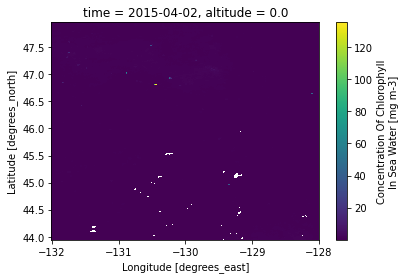

In [14]:
chl_xr.chlorophyll.isel(time=1).plot(x="longitude")

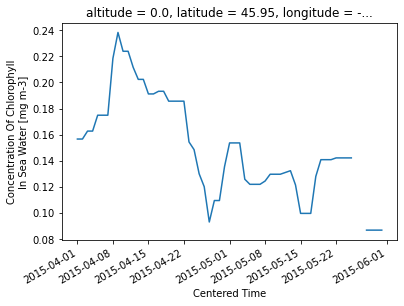

In [15]:
chl1d = chl_xr.chlorophyll.sel(latitude=ax_lat, longitude=ax_lon, method='nearest')
chl1d.plot()

**SST**

In [16]:
sst_xr

<xarray.Dataset>
Dimensions:         (time: 61, latitude: 401, longitude: 401)
Coordinates:
  * time            (time) datetime64[ns] 2015-04-01 2015-04-02 ... 2015-05-31
  * latitude        (latitude) float32 43.94 43.96 43.97 ... 47.92 47.94 47.94
  * longitude       (longitude) float32 -132.0 -132.0 -132.0 ... -128.0 -128.0
Data variables:
    SST             (time, latitude, longitude) float32 ...
    mask            (time, latitude, longitude) float32 ...
    analysis_error  (time, latitude, longitude) float32 ...
Attributes: (12/39)
    cdm_data_type:              Grid
    contact:                    Benyang.Tang@jpl.nasa.gov
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    creator_email:              Benyang.Tang@jpl.nasa.gov
    creator_name:               The JPL G1SST Team
    creator_type:               group
    ...                         ...
    standard_name_vocabulary:   CF Standard Name Table v70
    summary:                    A daily, global Sea Surface Temperature (SST)...
    time_coverage_end:          2015-05-31T00:00:00Z
    time_coverage_start:        2015-04-01T00:00:00Z
    title:                      GHRSST Global 1-km Sea Surface Temperature (G...
    Westernmost_Easting:        -131.995

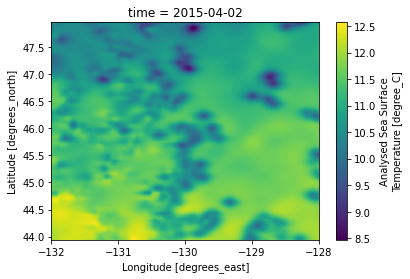

In [17]:
sst_xr.SST.isel(time=1).plot(x="longitude")

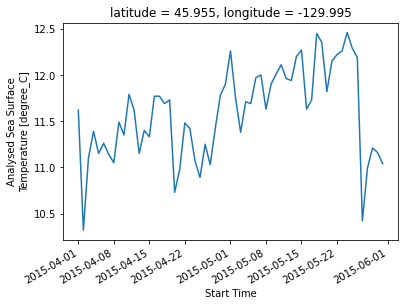

In [18]:
sst1d = sst_xr.SST.sel(latitude=ax_lat, longitude=ax_lon, method='nearest')
sst1d.plot()

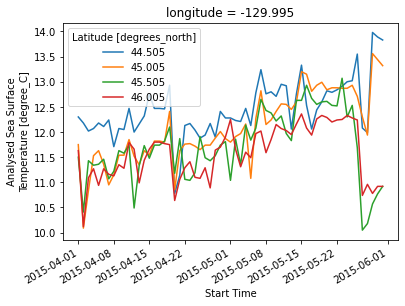

In [19]:
sst_xr.SST.sel(longitude=-130, latitude=[44.5, 45, 45.5, 46], method='nearest').plot.line(x="time")

*** Satelliite Extraction Takeaways and Next Steps
1) I need to go back in and take better notes in the satellite section
2) We can look at other dataset IDs